In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import patches, lines
import pickle
%matplotlib inline

colors = pickle.load(open('./colors.p', 'rb'))
sns.set(style='whitegrid', font_scale=1.2)

In [2]:
def plot_fitness_v_frequency(fitness, actual_frequencies, axes = None):
    if not axes:
        w = 7.5
        h = 8.75*2/3
        fig, axes = plt.subplots(2,1,figsize=(w,h), sharex=True, gridspec_kw={'wspace':0.025, 'hspace':0.1})
        show = True
    else:
        show = False
    for clade in fitness.columns.values:
        c = colors[clade]
        axes[1].plot(fitness[clade].index.values, fitness[clade], c=c, linestyle=':', label=clade)
        axes[0].plot(actual_frequencies[clade].index.values, actual_frequencies[clade], c=c, linestyle='-')

    axes[1].set_ylabel('Estimated fitness')
    axes[0].set_ylabel('Observed frequency')
    
    axes[0].set_ylim(0,1)
    axes[0].set_xlim(actual_frequencies.index.min(), fitness.index.max())
    axes[1].set_xlim(actual_frequencies.index.min(), fitness.index.max())
    plt.sca(axes[0])
    
    if not show:
        return axes
    else:
        plt.show()

In [78]:
def plot_growth_rates(actual, predicted, ax=None, c = 'gray', trajectory_demo_clade=None, trajectory_demo=None):
    '''
    For the actual and predicted actual_frequencies, find where both values are non-null and > 0.1
    Plot actual vs. predicted
    '''
    if not ax:
        w = 7.5/3
        h = w
        fig, ax = plt.subplots(figsize=(w,h))
        show = True
    else:
        show = False
    
    actual = actual.loc[actual.index.isin(predicted.index.values)]

    assert predicted.columns.tolist() == actual.columns.tolist()
    assert actual.index.tolist() == predicted.index.tolist()

    actual, predicted = actual.values.flatten(), predicted.values.flatten()
    mask = (~np.isnan(actual)) & (~np.isnan(predicted))
    fit = stats.linregress(actual[mask], predicted[mask])

    sns.regplot(actual[mask], predicted[mask], ax = ax, scatter_kws={'alpha': 0.2}, color = c)
    
    if trajectory_demo_clade and trajectory_demo:
        ax.scatter(*trajectory_demo, c=colors[trajectory_demo_clade], alpha=1.0, zorder=10000000)
    
    ax.set_xlabel('Observed growth rate')
    ax.set_ylabel('Predicted growth rate')
    ax.text(1,1,r'Pearson $r =$%.2f'%fit[2], transform=ax.transAxes, ha='right', va='top', fontsize=12)    
    
    max_val = actual[mask].flatten().max()
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.set_yticks(ax.get_xticks())
    fp = patches.Rectangle((1,0), width=10, height = 1, 
                           fc = 'gray',  alpha=0.3)
    fn = patches.Rectangle((0,1), width = 1, height = 10, 
                           fc= 'gray', alpha = 0.3)
    ax.add_patch(fp)
    ax.add_patch(fn)    
    if show:
        plt.show()
    else:
        return ax

# plot_growth_rates(actual_growth_rates, prediced_growth_rates, c = colors['interserotype_effects'])

In [79]:
def add_subfigure_label(ax, label, x=-0.13, y=1.0):
    ax.text(x, y, label, va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=ax.transAxes)

In [80]:
def plot_trajectory_example(actual_frequencies, predicted_trajectory, ax = None):
    if not ax:
        fig, ax = plt.subplots(figsize=(7.5*2/3, 7.5/3))
        show = True
    else:
        show = False
    
    t0 = predicted_trajectory.index.min() # trajectory start
    tf = predicted_trajectory.index.max() # trajectory end
    t_back = t0 - 2. # window start
    t_fwd = t0 + 2. # window end
    
    for clade, trajectory in predicted_trajectory.iteritems():
        if clade=='DENV1':
            c = colors[clade]
            x0 = actual_frequencies[clade][t0] # actual init freq
            xf = actual_frequencies[clade][tf] # actual final freq
            xhatf = predicted_trajectory[clade][tf] # predicted final freq
            
            ## Plot actual frequency over the whole window
            actual_vals = actual_frequencies[clade][t_back:t_fwd]
            ax.plot(actual_vals.index.values, actual_vals.values, c=c)
            
            ## Plot predicted trajectory
            ax.plot(trajectory.index.values, predicted_trajectory[clade].values, c=c, marker='o')
            
            ## Plot growth rate guidelines
            ax.plot([t0, tf], [x0, x0], c='gray', linestyle='--') # mark initial frequency
            
            ax.plot([tf+0.12, tf+0.12], [x0, xf], c='gray', linestyle='-')  # span actual intial -> final frequency
            ax.plot([tf-.08+0.12, tf+.08+0.12], [x0, x0], c='gray', linestyle='-') # marker caps
            ax.plot([tf-.08+0.12, tf+.08+0.12], [xf, xf], c='gray', linestyle='-')
            ax.text(tf+0.18, (x0+xf)*2./3., r'$g$', va='center')
            
            ax.plot([tf+0.2+0.12, tf+0.2+0.12], [x0, xhatf], c='gray', linestyle='-') # span actual initial -> predicted final 
            ax.plot([tf+0.1+0.12, tf+0.3+0.12], [x0, x0], color='gray', linestyle='-') # marker caps
            ax.plot([tf+0.1+0.12, tf+0.3+0.12], [xhatf, xhatf], color='gray', linestyle='-')
            ax.text(tf+0.42, (x0+xhatf)/2., r'$\hat{g}$', va='center')
            
    ax.set_xlim(t_back, t_fwd+0.8)
    ax.set_ylim(0,1)
    ax.set_ylabel('Frequency')
    
    if show:
        plt.show()
    else:
        return ax

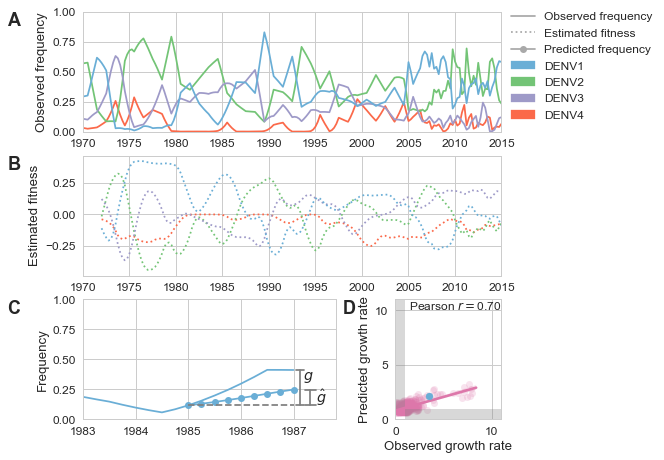

In [87]:
##### SEROTYPES: composite Figure 4

actual_frequencies = pd.read_csv('../data/frequencies/seasia_serotype_frequencies.csv', index_col=0)
predicted_fitness = pd.read_csv('../fitness_model/southeast_asia/serotype/serotype_fitness.csv', index_col=0)
predicted_growth_rates = pd.read_csv('../fitness_model/southeast_asia/serotype/serotype_predicted_growth_rates.csv', index_col=0)
actual_growth_rates = pd.read_csv('../fitness_model/southeast_asia/serotype/serotype_actual_growth_rates.csv', index_col=0)
trajectory = pd.read_csv('../fitness_model/southeast_asia/serotype/serotype_1985.0_trajectory.csv', index_col=0)

## Pull the final actual and predicted growth rates from the trajectory example in panel C
trajectory_demo_idx = str(trajectory.index.values.max())+'/'+str(trajectory.index.values.max()-2.)
trajectory_demo_clade = 'DENV1'
trajectory_demo = [actual_growth_rates[trajectory_demo_clade][trajectory_demo_idx], predicted_growth_rates[trajectory_demo_clade][trajectory_demo_idx]]

### Create and label axes
fig = plt.figure(figsize=(7.5, 7.5))
axes = gridspec.GridSpec(nrows = 3, ncols=3, width_ratios=[1., 1., 1.1], wspace=0.6)
actual_freq_ax = plt.subplot(axes[0,:])
add_subfigure_label(actual_freq_ax, 'A', x=-0.18)
fitness_ax = plt.subplot(axes[1,:])
add_subfigure_label(fitness_ax, 'B', x=-0.18)
trajectory_ax = plt.subplot(axes[2,:-1])
add_subfigure_label(trajectory_ax, 'C', x=-0.3)
growth_ax = plt.subplot(axes[2, -1])
add_subfigure_label(growth_ax, 'D', x=-0.5)

### Plot all four panels
plot_fitness_v_frequency(predicted_fitness, actual_frequencies, axes=[actual_freq_ax, fitness_ax])
plot_trajectory_example(actual_frequencies, trajectory, ax=trajectory_ax)
plot_growth_rates(actual_growth_rates, predicted_growth_rates,ax=growth_ax, c=colors['interserotype_effects'],
                 trajectory_demo_clade = trajectory_demo_clade, trajectory_demo=trajectory_demo)
growth_ax.set_xlim(0, 11) ## Square up plot so aspect = 1
growth_ax.set_ylim(0,11)

### Create legend
legend_handles = [ lines.Line2D([], [], color='darkgray', linestyle='-',label='Observed frequency'),
                   lines.Line2D([], [], color='darkgray', linestyle=':',label='Estimated fitness'),
                   lines.Line2D([], [], color='darkgray', marker='o',label='Predicted frequency')]
legend_labels = ['Observed frequency', 'Estimated fitness', 'Predicted frequency']

for cl in actual_frequencies.columns.values:
    legend_patch = patches.Patch( color=colors[cl], label=cl)
    legend_handles.append(legend_patch)
    legend_labels.append(cl)

fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.2,0.9),bbox_transform=plt.gcf().transFigure)
plt.savefig('./png/serotype_fitness_model.png', dpi=300, bbox_inches='tight')

In [89]:
### GENOTYPES: Figure 5
actual_frequencies = pd.read_csv('../data/frequencies/seasia_genotype_frequencies.csv', index_col=0)
actual_growth_rates = pd.read_csv('../fitness_model/southeast_asia/genotype/interserotype_model/genotype_interserotype_actual_growth_rates.csv', index_col=0)
all_effects_growth_rates = pd.read_csv('../fitness_model/southeast_asia/genotype/fulltree_model/genotype_fulltree_predicted_growth_rates.csv', index_col=0)
all_effects_fitness = pd.read_csv('../fitness_model/southeast_asia/genotype/fulltree_model/genotype_fulltree_fitness.csv', index_col=0)
interserotype_growth_rates = pd.read_csv('../fitness_model/southeast_asia/genotype/interserotype_model/genotype_interserotype_predicted_growth_rates.csv', index_col=0)
# interserotype_fitness = pd.read_csv('../fitness_model/southeast_asia/genotype/interserotype_model/genotype_interserotype_fitness.csv', index_col=0)
# interserotype_predicted_frequencies = pd.read_csv('../fitness_model/southeast_asia/genotype/interserotype_model/seasia_genotype_interserotype_sse_predicted_freqs.csv', index_col=0)

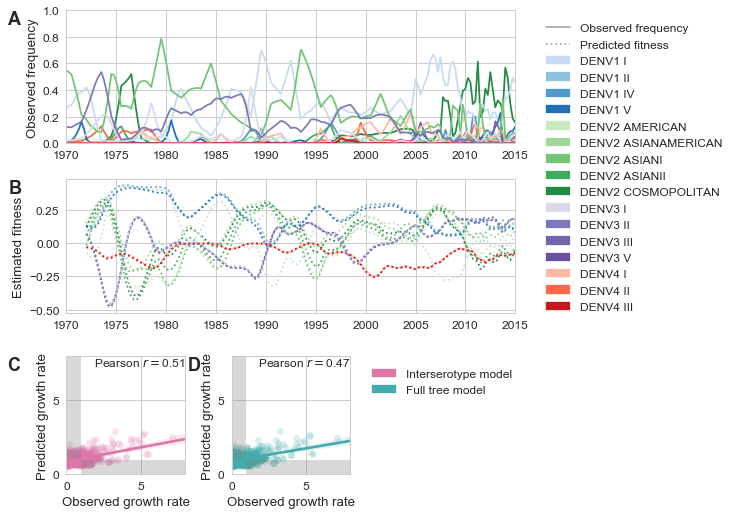

In [96]:
### Create and label axes
fig = plt.figure(figsize=(7.5, 7.5))
axes = gridspec.GridSpec(nrows = 3, ncols=3)
    
actual_freq_ax = plt.subplot(axes[0,:])
add_subfigure_label(actual_freq_ax, 'A')
fitness_ax = plt.subplot(axes[1,:])
add_subfigure_label(fitness_ax, 'B')
all_effects_ax = plt.subplot(axes[2,1])
add_subfigure_label(all_effects_ax, 'D', x=-0.37)
interserotype_effects_ax = plt.subplot(axes[2,0])
add_subfigure_label(interserotype_effects_ax, 'C', x=-0.5)

### Populate all four axes
plot_fitness_v_frequency(all_effects_fitness, actual_frequencies, axes=[actual_freq_ax, fitness_ax])
plot_growth_rates(actual_growth_rates, all_effects_growth_rates,all_effects_ax,c=colors['all_effects'])
plot_growth_rates(actual_growth_rates, interserotype_growth_rates,interserotype_effects_ax,c=colors['interserotype_effects'])

### Create legend
legend_handles = [ lines.Line2D([], [], color='darkgray', linestyle='-',label='Observed frequency'),
                   lines.Line2D([], [], color='darkgray', linestyle=':',label='Estimated fitness'),]
legend_labels = ['Observed frequency', 'Predicted fitness']
for cl in sorted(actual_frequencies.columns.values.tolist()):
    legend_patch = patches.Patch( color=colors[cl], label=cl.replace('_', ' '))
    legend_handles.append(legend_patch)
    legend_labels.append(cl.replace('_', ' '))

fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.35,.96),bbox_transform=plt.gcf().transFigure)
    
all_effects_ax.set_xlim(0,8)
all_effects_ax.set_ylim(0,8)
all_effects_ax.set_aspect(1)
interserotype_effects_ax.set_xlim(0,8)
interserotype_effects_ax.set_ylim(0,8)
interserotype_effects_ax.set_aspect(1)
fig.legend([patches.Patch(color=colors['interserotype_effects'], label='Interserotype model'),
            patches.Patch(color=colors['all_effects'], label='Full tree model')],
           ['Interserotype model', 'Full tree model'], bbox_to_anchor=(0.96, 0.32),bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.savefig('./png/genotype-fitness.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
# ## GENOTYPES: FIGURE 6

# fig = plt.figure(figsize=(7.5*2/3, 7.5/3))
# axes = gridspec.GridSpec(nrows = 1, ncols=2)
    
# all_effects_ax = plt.subplot(axes[0,0])
# interserotype_effects_ax = plt.subplot(axes[0,1])

# plot_growth_rates(actual_growth_rates, all_effects_growth_rates,all_effects_ax,c=colors['all_effects'])
# plot_growth_rates(actual_growth_rates, interserotype_growth_rates,interserotype_effects_ax,c=colors['interserotype_effects'])

# legend_handles = [patches.Patch(color=colors['all_effects']),patches.Patch(color=colors['interserotype_effects'])]
# legend_labels = ['Full tree model', 'Interserotype model']

# fig.legend(legend_handles, legend_labels,bbox_to_anchor=(1.4,.93),bbox_transform=plt.gcf().transFigure)
# plt.savefig('./png/genotype_growth_rates.png', dpi=300, bbox_inches='tight')
# plt.show()

In [33]:
# def dominant_strain(tp, frequencies):
#     return frequencies.loc[tp].idxmax()
    
# def find_dominant_period(start_tp, frequencies):
#     start_clade = dominant_strain(start_tp, frequencies)
#     timepoints = frequencies.index.tolist()
    
#     tp_idx = timepoints.index(start_tp)
#     clade = start_clade
    
#     while clade == start_clade and tp_idx < len(timepoints)-1:
#         clade = dominant_strain(timepoints[tp_idx], frequencies)
#         tp_idx += 1
#     else:
#         return timepoints[tp_idx]
    
# def find_avg_dominance_length(frequencies):
    
#     timepoints = frequencies.index.tolist()
#     tp_idx = 0
    
#     turnover_length = []

#     while tp_idx < len(timepoints):
#         start = timepoints[tp_idx]
#         end = find_dominant_period(start, frequencies)
#         turnover_length.append(end - start)
#         tp_idx = timepoints.index(end)+1
        
#     return float(sum(turnover_length))/float(len(turnover_length))

# serotype_turnover_len = find_avg_dominance_length(actual_frequencies)
# print serotype_turnover_len